In [1]:
!pip install -q mlflow

In [2]:
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
%matplotlib inline

# Dataset
### Montgomery and Shenzhen for train
https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

In [3]:
image_path_train = '../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/'
mask_path_train = '../input/chest-xray-masks-and-labels/Lung Segmentation/masks/'
image_path_test = '../input/chest-xray-masks-and-labels/Lung Segmentation/test/' 

### images
* 'CHNCXR_0242_0.png'
* 'MCUCXR_0017_0.png'

### mask
* 'MCUCXR_0017_0.png'
* 'CHNCXR_0337_1_mask.png'

In [4]:
images = os.listdir(image_path_train)
mask = os.listdir(mask_path_train)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [5]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:", len(check))

Total mask that has modified name: 566


In [6]:
testing_files = set(os.listdir(image_path_train)) & set(os.listdir(mask_path_train))
training_files = check

In [7]:
def getData(X_shape, flag = "MONT"):
    im_array = []
    mask_array = []
    shape = (X_shape, X_shape)
    # X_shape = image_size
    if flag == "MONT":
        for i in tqdm(testing_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i))
            im = cv2.resize(im, shape)[:, :, 0]
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i))
            mask = cv2.resize(mask, shape)[:, :, 0]
            
            im_array.append(im)
            mask_array.append(mask)
    
    if flag == "SHEN":
        for i in tqdm(training_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i.split("_mask")[0] + ".png"))
            im = cv2.resize(im, shape)[:, :, 0]
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i + ".png"))
            mask = cv2.resize(mask, shape)[:, :, 0]
            
            im_array.append(im)
            mask_array.append(mask)
    # return list
    return im_array, mask_array

In [8]:
def get_test(X_shape, n_samples = 100):
    im_array = []
    shape = (X_shape, X_shape)
    test_files = random.choices(list(os.listdir(image_path_test)), k=n_samples)
    for i in tqdm(test_files):
        im = cv2.imread(os.path.join(image_path_test, i))
        im = cv2.resize(im, shape)[:, :, 0]
        im = cv2.equalizeHist(im)
        im_array.append(im)
    return im_array

# Loading images and masks

In [9]:
dim, n_samples = 256, 50 # n_samples = [1, 96]

image_shen, mask_shen = getData(dim, flag = "SHEN")
image_mont, mask_mont = getData(dim, flag = "MONT")
X_test = get_test(dim, n_samples = n_samples)

100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


In [10]:
image_shen = np.array(image_shen).reshape(len(image_shen), dim, dim, 1)
mask_shen = np.array(mask_shen).reshape(len(mask_shen), dim, dim, 1)

image_mont = np.array(image_mont).reshape(len(image_mont), dim, dim, 1)
mask_mont = np.array(mask_mont).reshape(len(mask_mont), dim, dim, 1)

X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)

In [11]:
print(image_shen.shape, mask_shen.shape)
print(image_mont.shape, mask_mont.shape)
print(X_test.shape)

(566, 256, 256, 1) (566, 256, 256, 1)
(138, 256, 256, 1) (138, 256, 256, 1)
(50, 256, 256, 1)


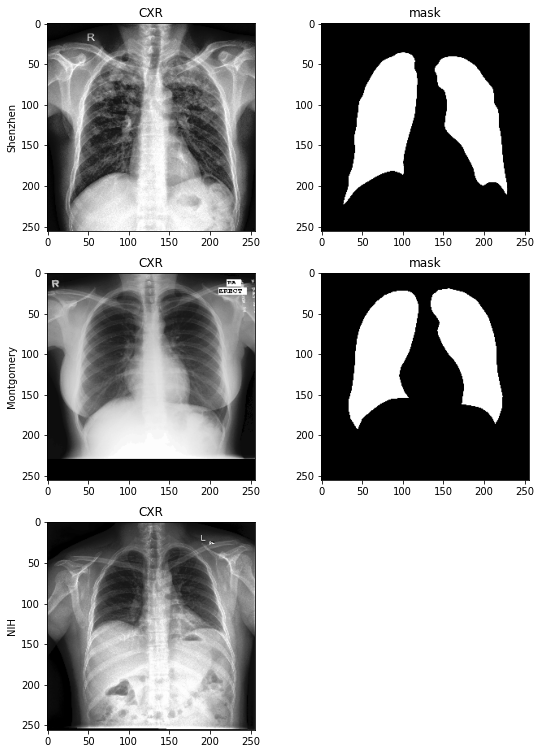

In [12]:
i = 25
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 13))
axs[0, 0].imshow(image_shen[i], cmap='gray')
axs[0, 1].imshow(mask_shen[i], cmap='gray')
axs[0, 0].set_ylabel('Shenzhen')

axs[1, 0].imshow(image_mont[i], cmap='gray')
axs[1, 1].imshow(mask_mont[i], cmap='gray')
axs[1, 0].set_ylabel('Montgomery')

axs[2, 0].imshow(X_test[i], cmap='gray')
axs[2, 0].set_ylabel('NIH')

axs[0, 0].set_title('CXR')
axs[1, 0].set_title('CXR')
axs[2, 0].set_title('CXR')

axs[0, 1].set_title('mask')
axs[1, 1].set_title('mask')

fig.delaxes(axs[2, 1])

In [13]:
assert image_shen.shape == mask_shen.shape
assert image_mont.shape == mask_mont.shape
images = np.concatenate((image_shen, image_mont), axis=0)
masks  = np.concatenate((mask_shen, mask_mont), axis=0)

print(images.shape, masks.shape)

(704, 256, 256, 1) (704, 256, 256, 1)


**image size** = (256 x 256) 

_for memory matters_

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split((images - 127.0) / 127.0, 
                                                  (masks > 127).astype(np.float32), 
                                                  test_size = 0.15, 
                                                  random_state = 2018)
X_testNorm = (X_test - 127.0) / 127.0

# Rsidual U-Net

based on https://github.com/nikhilroxtomar/Deep-Residual-Unet?ref=morioh.com&utm_source=morioh.com

In [15]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
import mlflow
import mlflow.tensorflow

2021-09-20 07:44:41.907268: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [16]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred) 

In [17]:
def bn_act(x, act=True):
    x = tensorflow.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tensorflow.keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = tensorflow.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = tensorflow.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = tensorflow.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tensorflow.keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = tensorflow.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tensorflow.keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
    c = tensorflow.keras.layers.Concatenate()([u, xskip])
    return c

In [18]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = tensorflow.keras.layers.Input((dim, dim, 1))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tensorflow.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tensorflow.keras.models.Model(inputs, outputs)
    return model

In [19]:
metrics = [dice_coef, jaccard_coef,
           'binary_accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC()]

loss = [dice_coef_loss, 
        jaccard_coef_loss,
        'binary_crossentropy']

2021-09-20 07:44:45.920984: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-20 07:44:45.923865: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-20 07:44:45.959669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 07:44:45.960285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-20 07:44:45.960357: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-20 07:44:45.985229: I tensorflow/stream_executor/platform/def

In [20]:
mlflow.autolog()

2021/09/20 07:44:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/09/20 07:44:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [21]:
model = ResUNet()
adam = tensorflow.keras.optimizers.Adam()
model.compile(optimizer=adam, loss=loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
weight_path="{}_res_unet.hdf5".format('cxr_seg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

In [23]:
res = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=32, epochs=80,
                callbacks=[checkpoint])

2021/09/20 07:44:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bc5f49a0d7fb4a77816c4732a7384b25', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2021-09-20 07:44:49.288685: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-20 07:44:49.288729: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-20 07:44:49.289348: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2021-09-20 07:44:49.305679: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.11.0
2021-09-20 07:44:49.535157: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-20 07:44:49.535372: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2021-09-20 07:44:50.05

Epoch 1/80


2021-09-20 07:44:53.738790: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-09-20 07:44:58.841700: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-20 07:44:59.557193: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


 1/19 [>.............................] - ETA: 3:56 - loss: 0.6392 - dice_coef: 0.3608 - jaccard_coef: 0.2201 - binary_accuracy: 0.5149 - precision: 0.2859 - recall: 0.5764 - auc: 0.5444

2021-09-20 07:45:03.341223: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-20 07:45:03.341273: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/19 [==>...........................] - ETA: 16s - loss: 0.5830 - dice_coef: 0.4170 - jaccard_coef: 0.2686 - binary_accuracy: 0.5479 - precision: 0.3237 - recall: 0.6688 - auc: 0.6416 

2021-09-20 07:45:04.231591: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-20 07:45:04.232574: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2021-09-20 07:45:04.375958: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 928 callback api events and 896 activity events. 
2021-09-20 07:45:04.399991: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-20 07:45:04.428098: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tmp5gwa408b/train/plugins/profile/2021_09_20_07_45_04
2021-09-20 07:45:04.443944: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/tmp5gwa408b/train/plugins/profile/2021_09_20_07_45_04/bcf124b36f40.trace.json.gz
2021-09-20 07:45:04.490959: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating dir

19/19 [==============================] - 28s 808ms/step - loss: 0.2817 - dice_coef: 0.7185 - jaccard_coef: 0.5961 - binary_accuracy: 0.8111 - precision: 0.6239 - recall: 0.8505 - auc: 0.9033 - val_loss: 0.4322 - val_dice_coef: 0.5652 - val_jaccard_coef: 0.3941 - val_binary_accuracy: 0.6033 - val_precision: 0.3844 - val_recall: 0.9949 - val_auc: 0.8935

Epoch 00001: val_loss improved from inf to 0.43221, saving model to cxr_seg_res_unet.hdf5
Epoch 2/80
19/19 [==============================] - 10s 549ms/step - loss: 0.0621 - dice_coef: 0.9379 - jaccard_coef: 0.8833 - binary_accuracy: 0.9699 - precision: 0.9532 - recall: 0.9268 - auc: 0.9748 - val_loss: 0.2186 - val_dice_coef: 0.7809 - val_jaccard_coef: 0.6405 - val_binary_accuracy: 0.8743 - val_precision: 0.6714 - val_recall: 0.9661 - val_auc: 0.9453

Epoch 00002: val_loss improved from 0.43221 to 0.21862, saving model to cxr_seg_res_unet.hdf5
Epoch 3/80
19/19 [==============================] - 10s 550ms/step - loss: 0.0476 - dice_coef: 

2021-09-20 07:59:08.807202: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021/09/20 07:59:19 ERROR mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpol9u_ocr/model, flavor: keras)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/mlflow/utils/environment.py", line 212, in infer_pip_requirements
    return _infer_requirements(model_uri, flavor)
  File "/opt/conda/lib/python3.7/site-packages/mlflow/utils/requirements_utils.py", line 256, in _infer_requirements
    _MODULES_TO_PACKAGES = importlib_metadata.packages_distributions()
AttributeError: module 'importlib_metadata' has no attribute 'packages_distributions'


In [24]:
model.save('cxr_resunet.h5')

In [25]:
from IPython.display import FileLink
FileLink(r'cxr_resunet.h5')

/kaggle/working/cxr_resunet.h5

## plot model response

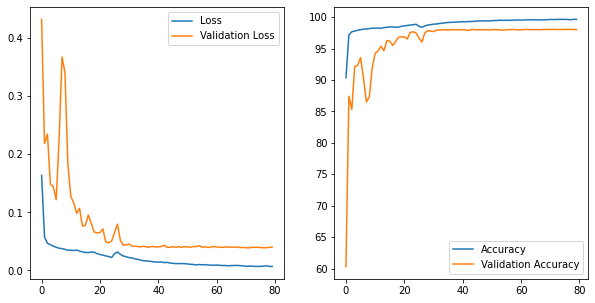

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(res.history['loss'], '-', label = 'Loss')
ax1.plot(res.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(res.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(res.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

## prediction on test set

In [27]:
preds = model.predict(X_testNorm)

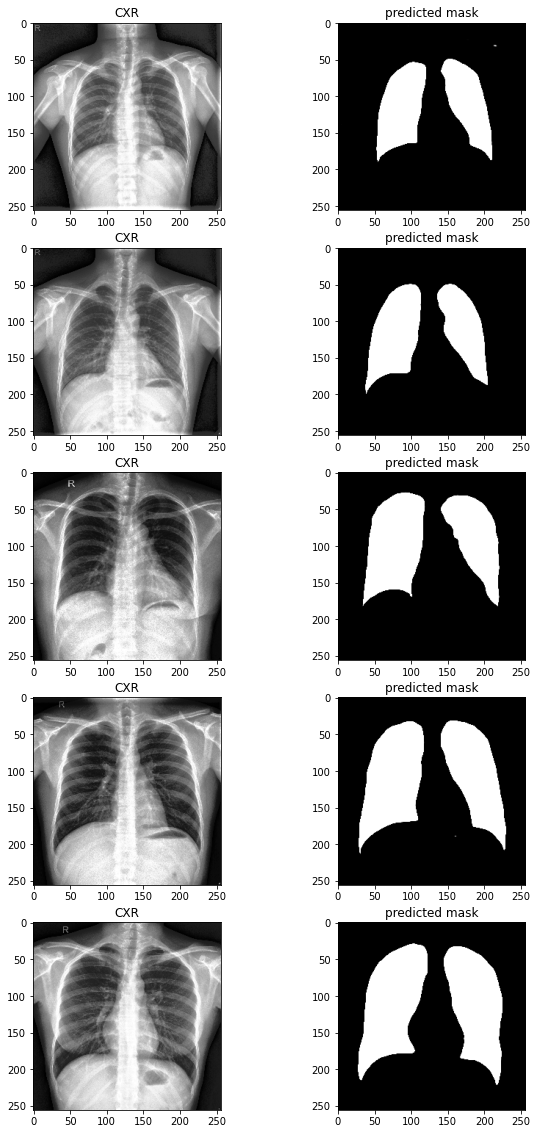

In [28]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for i in range(5):
    for j in range(2):
        if j != 1:
            axs[i, j].imshow(X_testNorm[i + 10], cmap='gray')
            axs[i, j].set_title('CXR')
        else:
            axs[i, j].imshow(preds[i + 10], cmap='gray')
            axs[i, j].set_title('predicted mask')

In [42]:
!zip mlflow_resunet ./mlruns

  adding: mlruns/ (stored 0%)


In [43]:
from IPython.display import FileLink
FileLink(r'./mlflow_resunet.zip')

/kaggle/working/mlflow_resunet.zip